# Julia Notebook

Based on the demo from NN tutorial 1.

1. Google Colab
2. Data loading
3. MLP forward pass
4. Batching/vectorization
5. Automatic differentiation
6. MLP gradient descent
7. MLP using Keras

# 1) Google Colab

To activate your Colab notebook for GPU usage, go to `Runtime > Change runtime type` and select `GPU` as hardware accelerator. Then, run the following to check your device availability.

In [1]:
!nvidia-smi

Mon May 24 11:30:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.09       Driver Version: 461.09       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 165... WDDM  | 00000000:57:00.0 Off |                  N/A |
| N/A   47C    P8     4W /  N/A |    134MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 2) Loading the data

Load each datafile into jupyter, extract their $x$ and $y$ entries, and store the results in matrices.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets

In [4]:
# x: (n_samples, x_ver_dim, x_hor_dim) with x_ver_dim = x_hor_dim = 512 (so in total 512^2 pixel)
# y: (n_samples, y_dim) with y_dim=2 (the julia constant and the starting coordinate)

dataList = []
ytargetList = []
# load first 10 datapoints for testing
for fileIndex in range(10):
    with open('../trainingData/data'+str(fileIndex)+'.jset', 'r') as file:
        ytargetString = file.readline()[2:].rstrip()
        lines = file.readlines()
    ytargetList.append(np.fromstring(ytargetString, dtype=float, sep=','))
    #dataList.append([np.fromstring(line, dtype=float, sep=',') for line in lines])
    x = [np.fromstring(line, dtype=float, sep=',') for line in lines]
    x = np.array(x)
    for i in range(26):
        for j in range(26):
            x[i, j] = np.mean(x[i*20:(i+1)*20, j*20:(j+1)*20])
    x = x[:26,:26].reshape(676)
    #x = x.reshape(271441)
    dataList.append(x)
#convert lists into numpy matrices
data = np.array(dataList)
ytarget = np.array(ytargetList)
print('data points:', data.shape)
print('targets:', ytarget.shape)

data points: (10, 676)
targets: (10, 2)


Visualize the four first data points $x$ as images along with their parameters.

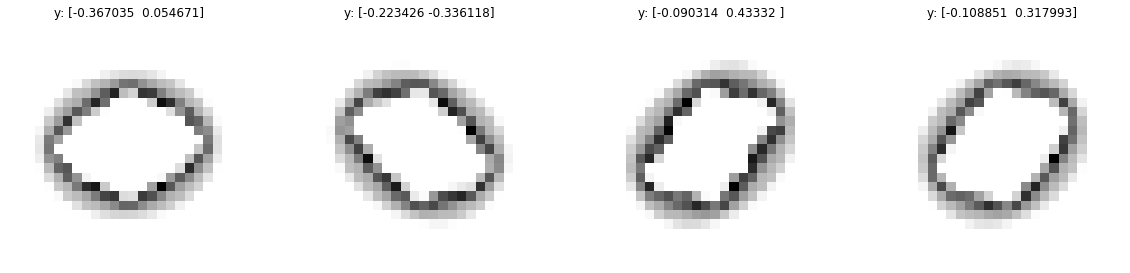

In [5]:
# plotting example images
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
for ax, image, label in zip(axes, data[:4], ytarget[:4]):
    image = image.reshape(26, 26)
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r)
    ax.set_title('y: {}'.format(label))

# 3) Dimensionality reduction using a VAE (Variational Auto-Encoder)

Source: https://avandekleut.github.io/vae/


In [6]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


Below we write the `Encoder` class by sublcassing `torch.nn.Module`, which lets us define the `__init__` method storing layers as an attribute, and a `forward` method describing the forward pass of the network.

In [8]:
print('data points:', data.shape)
print('targets:', ytarget.shape)

class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(676, 512)
        self.linear2 = nn.Linear(512, latent_dims)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

data points: (10, 676)
targets: (10, 2)


We do something similar for the `Decoder` class, ensuring we reshape the output.

In [9]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 676)
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 26, 26))

Finally, we write an `Autoencoder` class that combines these two. Note that we could have easily written this entire autoencoder as a single neural network, but splitting them in two makes it conceptually clearer.

In [10]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

Next, we will write some code to train the autoencoder on the MNIST dataset.

In [2]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, _ in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder

# 3) Building a MLP (forward pass)

Our goal is to build a feedforward neural network (MLP) to accurately classify these images of digits. We will feed a 64-dimensional input vector into the network and expect a 10-dimensional output vector, where element $i$ ($i \in \{0, \ldots, 9\}$) of the output vector corresponds to the network's estimated probability that the input image is showing the digit $i$. 

# 3) Building a MLP (forward pass)

Our goal is to build a feedforward neural network (MLP) to accurately classify these images of digits. We will feed a 64-dimensional input vector into the network and expect a 10-dimensional output vector, where element $i$ ($i \in \{0, \ldots, 9\}$) of the output vector corresponds to the network's estimated probability that the input image is showing the digit $i$. 

We first setup the model's hyperparameters - in our case we only specify the number of units in each layer of the network and `initial_scaling` - the scaling of our initial weight and bias values.

Then we also initialize the model parameters - these are the weights and biases of the network in each layer.

In [17]:
# network hyperparameters
layers = [x.shape[1], 500, 500, ytarget.shape[1]]
initial_scaling = 0.01

# model parameters
# list(tuple(weight_mat, bias_vec))
params = [
    (
        # weights
        np.random.normal(size=(layers[i+1], layers[i])) * initial_scaling,
        # bias
        np.random.normal(size=(layers[i+1],)) * initial_scaling
    )
    for i in range(len(layers)-1)
]

# check parameters
print([list(map(lambda x: x.shape, params[i])) for i in range(len(params))])

NameError: name 'x' is not defined

We implement the forward pass of the network as a function taking in the network parameters and the input vector.

In [ ]:
def nn_forward(params, x):
    # x: (x_dim) - vector!
    state = x
    # pass through input and hidden layers
    for wi, bi in params[:-1]:
        # first iteration
        # state: (x_dim,)
        # wi: (hid1_dim, x_dim)
        # bi: (hid1_dim)
        state = np.dot(wi, state) + bi
        state = np.tanh(state)
    # pass through output layer
    wf, bf = params[-1]
    logits = np.dot(wf, state) + bf
    # softmax (normalize to prob distr)
    return np.exp(logits) / np.sum(np.exp(logits))

In [ ]:
# check forward pass
ypred = nn_forward(params, x[0,:])
print('ypred:', ypred)
print('ypred sum:', ypred.sum())
print('Predicted digit:', np.argmax(ypred) + 1)

This is fine, but we are going to feed in around 2000 image vectors per training epoch (and potentially we will be training the network for many epochs). To do this more efficiently, we need to **batch** the inputs to the forward pass.

# 5) Batching (naive and using JAX)

We will compare three different methods for implementing the batched forward pass:
1. naive batching (for loop)
2. rewriting function for input batches
3. using JAX's vectorization function

To learn more about JAX, visit https://github.com/google/jax. In short, JAX is a Python package to automatically differentiate, vectorize and optimize Python and NumPy programs with CPU, GPU, and TPU support. It is maintained by Google Research and actively using in Machine Learning and Neural Networks research at Google, DeepMind, and other leading high-performance ML research institutions. 

In [ ]:
# naive batching
ypred = np.array([nn_forward(params, x[i, :]) for i in range(x.shape[0])])

As you can imagine, this naive way of batching is not optimized at all.

In [ ]:
# rewriting function for input batches
def nn_forward_batch(params, x):
    # x: (batch_size, x_dim) - matrix
    state = x
    # pass through input and hidden layers
    for wi, bi in params[:-1]:
        # first iteration
        # state: (batch_size, x_dim)
        # wi: (hid1_dim, x_dim)
        # bi: (hid1_dim)
        state = np.dot(wi, state.T).T + bi # numpy broadcasting!
        state = np.tanh(state)
    # pass through output layer
    wf, bf = params[-1]
    logits = np.dot(wf, state.T).T + bf
    # softmax (normalize to prob distr)
    return (np.exp(logits).T / np.sum(np.exp(logits), axis=1)).T

This is much better - instead of doing many vector operations sequentially, we are doing just one pass of matrix operations. This is great, but such a rewriting can be very time-consuming and for more complex functions, it can become a great source of bugs.

Next up, we will be using **JAX** to automatically vectorize (i.e. batch) our function. For this, we need to first rewrite our function from using `numpy` to using `jax.numpy` aka `jnp`. A key difference here is JAX's usage of keys for their pseudo-random number generator. 

In [ ]:
import jax
import jax.numpy as jnp

# random key
key = jax.random.PRNGKey(0)

# JAX arrays -> device optimized
a = jax.random.normal(key, (25, 35))
a.shape

Note the warning that JAX is *falling back to CPU*, implying that the default way of running JAX is on GPUs or TPUs. This is reflected in the JAX arrays being of type `DeviceArray` - with device-specific optimizations out of the box:

In [ ]:
type(a)

Simply replace `np` with `jnp`:

In [ ]:
def nn_forward_jnp(params, x):
    # x: (x_dim) - vector!
    state = x
    # pass through input and hidden layers
    for wi, bi in params[:-1]:
        # first iteration
        # state: (x_dim,)
        # wi: (hid1_dim, x_dim)
        # bi: (hid1_dim)
        state = jnp.dot(wi, state) + bi
        state = jnp.tanh(state)
    # pass through output layer
    wf, bf = params[-1]
    logits = jnp.dot(wf, state) + bf
    # softmax (normalize to prob distr)
    return jnp.exp(logits) / jnp.sum(jnp.exp(logits))

Automatically vectorizing (batching) a function is a simple one-liner in JAX. The `in_axes` parameter indicates what axes of the function inputs will be used for the batching (we don't want to batch the network `params`, only the `x` input). 

In [ ]:
nn_forward_batchd = jax.vmap(nn_forward_jnp, in_axes=(None, 0)) # that's it!

Let us run a time comparison:

In [ ]:
# naive batching
%timeit np.array([nn_forward(params, x[i, :]) for i in range(x.shape[0])])

In [ ]:
# manual batching
%timeit nn_forward_batch(params, x)

In [ ]:
# JAX batching
%timeit nn_forward_batchd(params, jnp.array(x))

JAX even managed to outperform our own manual implementation of the batching!!

# 6) Automatic differentiation

In order to implement gradient descent, we could write a `backward_pass` function for the neural network and manually program in the differentiation of the loss function with respect to the network parameters. This is quite tedious. 

Instead, we will use *automatic differentiation*, which is used under the hood in pretty much every deep learning framework (TensorFlow, PyTorch, Keras, etc.). This is **not** finite differences (a numeric method) - finite differences produces prohibitive round-off errors, and is inefficient as it requires a forward pass for every parameter with respect to which you want to differentiate. Neither is it fully symbolic differentiation, which (often) leads to much redundancy in computing the derivatives (the deep learning framework `Theano` uses symbolic differentiation). 

You can think of automatic differentiation as symbolic differentiation on computer programs (instead of on math expressions). One of its modes (forward mode) is mathematically equivalent to evaluating a function using dual numbers of the form $x + \dot x \epsilon$.

If you want to dive deeper into this (very interesting) topic, check out this [blog post](http://conal.net/blog/posts/what-is-automatic-differentiation-and-why-does-it-work) on automatic differentiation (or the accompanying [paper](http://conal.net/papers/beautiful-differentiation/beautiful-differentiation-long.pdf) and [presentation](https://vimeo.com/6622658)) or this [survey paper](https://jmlr.org/papers/volume18/17-468/17-468.pdf) on automatic differentiation in machine learning.

In [ ]:
def forward(x):
    return jnp.sin(x) * 2*x

def backward(x):
    return jnp.cos(x) * 2*x + 2*jnp.sin(x)

backward_jax = jax.grad(forward) # that's it!

In [ ]:
# demo
inp = jnp.arange(0, 50., 0.01)

In [ ]:
# compute
f = jax.vmap(forward)(inp)
b = jax.vmap(backward)(inp)
j = jax.vmap(backward_jax)(inp)

In [ ]:
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(inp, f)
ax.plot(inp, b, c='red')
ax.plot(inp, j, c='green', ls='--')
plt.show()

# 7) MLP in JAX (forward and backward)

We now use JAX's automatic differentiation to implement the backward step (gradient descent) for our MLP. 

In [ ]:
x = jnp.array(x)
ytarget = jnp.array(ytarget)

In [ ]:
x

We need to also translate our initial code to use JAX's version of numpy:

In [ ]:
layers = [x.shape[1], 512, 512, ytarget.shape[1]]
params = [
    (
        jax.random.normal(key, (layers[i+1], layers[i])) * 0.01,
        jax.random.normal(key, (layers[i+1],)) * 0.01
    )
    for i in range(len(layers)-1)
]
print([list(map(lambda x: x.shape, params[i])) for i in range(len(params))])

In [ ]:
def nn_forward(params, x):
    state = x
    for wi, bi in params[:-1]:
        state = jnp.dot(wi, state) + bi
        state = jnp.tanh(state)
    wf, bf = params[-1]
    logits = jnp.dot(wf, state) + bf
    return jnp.exp(logits) / jnp.sum(jnp.exp(logits))

In [ ]:
nn_forward_batch = jax.vmap(nn_forward, in_axes=(None, 0))

Now, we can implement the MSE loss function:

In [ ]:
def loss(params, x, ytarget):
    # takes in batch!
    # compute MSE loss
    ypred = nn_forward_batch(params, x)
    return jnp.square(ytarget - ypred).mean()

We will also want to compute the accuracy for a batch

In [ ]:
def accuracy(params, x, ytarget):
    # ypred (batch_size, y_dim)
    ypred = nn_forward_batch(params, x)
    return np.sum(ypred.argmax(axis=1) == ytarget.argmax(axis=1)) / ypred.shape[0]

And we are ready to implement the gradient descent step:

In [ ]:
@jax.jit 
def update_params(params, x, ytarget, step_size=1e-2):
    # does one epoch of training, then computes gradients, and one step of gradient descent
    # returns updated weights
    grads = jax.grad(loss)(params, x, ytarget)
    return [
        (
            w - step_size * dw, 
            b - step_size * db
        ) for (dw, db), (w, b) in zip(grads, params)
    ]

Before we can train the network, we need to split our data into training and testing sets:

In [ ]:
# shuffle dataset
permutation = jax.random.permutation(key, jnp.arange(x.shape[0]))
x_shuffled = x[permutation]
ytarget_shuffled = ytarget[permutation]

In [ ]:
# split 80:20
n_train = int(x.shape[0] * 0.8)
x_train = x_shuffled[:n_train]
yt_train = ytarget_shuffled[:n_train]
x_test = x_shuffled[n_train:]
yt_test = ytarget_shuffled[n_train:]

In [ ]:
x_train.shape, x_test.shape

In [ ]:
# save original (random) params
orig_params = params.copy()

In [ ]:
# training procedure
hist = []
num_epochs = 200
for i in range(num_epochs+1):
    step_size=max((0.2 - i*0.0001, 0.01))
    params = update_params(params, x_train, yt_train, step_size=step_size)
    # test
    test_loss = loss(params, x_test, yt_test)
    test_acc = accuracy(params, x_test, yt_test)
    # train
    train_loss = loss(params, x_train, yt_train)
    train_acc = accuracy(params, x_train, yt_train)
    # print
    if i % 10 == 0:
        print('epoch {:3} testing {:6.2%} training {:6.2%}'.format(
            i, test_acc, train_acc
        ), end='\n')
    # save 
    hist.append((
        test_loss, test_acc, train_loss, test_acc
    ))

This is worse than we like. One should expect a MLP with two hidden layers to get to >90% accuracy. The reason for this might be that we are updating the weights only once per epoch. To change this, we can implement a mini-batching procedure - to split the dataset into batches and update the parameters after each batch. That way, we increase the number of gradient updates. 

In [ ]:
def minibatch_update(params, x_train, yt_train, step_size):
    batch_size = 400
    batch_idx = 0
    while batch_idx*batch_size <= x_train.shape[0]:
        params = update_params(params, x_train[batch_idx*batch_size:(batch_idx+1)*batch_size], yt_train[batch_idx*batch_size:(batch_idx+1)*batch_size], step_size=step_size)
        batch_idx += 1
    params = update_params(params, x_train[batch_idx*batch_size:], yt_train[batch_idx*batch_size:], step_size=step_size)
    return params

In [ ]:
# restore original params
params = orig_params.copy()

In [ ]:
# training procedure
hist = []
num_epochs = 200
for i in range(num_epochs+1):
    step_size=max((0.2 - i*0.0001, 0.01))
    params = minibatch_update(params, x_train, yt_train, step_size=step_size)
    # test
    test_loss = loss(params, x_test, yt_test)
    test_acc = accuracy(params, x_test, yt_test)
    # train
    train_loss = loss(params, x_train, yt_train)
    train_acc = accuracy(params, x_train, yt_train)
    # print
    if i % 10 == 0:
        print('epoch {:3} testing {:6.2%} training {:6.2%}'.format(
            i, test_acc, train_acc
        ), end='\n')
    # save 
    hist.append((
        test_loss, test_acc, train_loss, test_acc
    ))

And indeed, this helps us get to >95% accuracy. 

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,4))
axs[0].set_title('loss')
axs[0].plot([e[0] for e in hist])
axs[0].plot([e[2] for e in hist])
axs[1].set_title('accuracy')
axs[1].plot([e[1] for e in hist])
axs[1].plot([e[3] for e in hist])
axs[1].set_ylim(0,1)
plt.show()

# 8) MLP in Keras

Now that we know how to implement a feedforward neural network manually, we can try using one of the deep learning frameworks to do the same thing. We will use Keras - it defines an API on top of TensorFlow and makes it very easy to build (simple) neural networks (somewhat sacrificing transparency/modifiability).

In [ ]:
import keras

In [ ]:
model = keras.models.Sequential()

In [ ]:
model.add(keras.layers.Dense(500, input_shape=(64, ), activation='tanh'))
model.add(keras.layers.Dense(500, activation='tanh'))
model.add(keras.layers.Dense(10, activation='softmax'))

In [ ]:
model.summary()

We now set up our learning algorithm. We are using stochastic gradient descent. We do not specify the batch size here and it is not obvious what is used. Looking at the Keras documentation (scroll down on [this page](https://keras.io/api/models/model_training_apis/)), we find that the `model.fit` method accepts a `batch_size` parameter. We do not specify it explicitly here, so Keras will use its default value of 32. This means that we will be doing mini batch gradient descent with a batch size of 32 (rather than 400, what we used in our JAX implementation).

In [ ]:
model.compile(optimizer='SGD',loss='mse', metrics=['accuracy'])
hist = model.fit(np.array(x_train), np.array(yt_train), epochs=100)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].set_title('train loss')
axs[0].plot(hist.__dict__['history']['loss'])
axs[1].set_title('train accuracy')
axs[1].plot(hist.__dict__['history']['accuracy'])
axs[1].set_ylim(0,1.1)
plt.show()

Note that the accuracy reported here is on the training dataset.

# "Dangers" of using deep learning frameworks

As you see here, Keras's ease of use is awesome. However, this easily leads to implement networks that you don't understand. While this can lead to good results, it is not what we want to see in your course projects. 

A good rule of thumb for your project: *don't use what you don't understand*.

When implementing a neural network with JAX, you have to take control of every part of the design and training process. You will implement the loss function, the batching, the cross-validation scheme, the gradient step size, the update step (stochastic/batch/mini-batch, momentum, scheduling), early stopping, etc etc. Frameworks can easily obscure this away from you. Consider the model that you understand:
```
model.compile(optimizer='SGD',loss='mse', metrics=['accuracy'])
```
it uses stochastic gradient descent and the MSE loss. You should know and understand how this works. Now consider this simple change:
```
model.compile(optimizer='Adam',loss='cross-entropy', metrics=['accuracy'])
```
It is very easy to run this model and you will see your model converge much faster:

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(500, input_shape=(64, ), activation='tanh'))
model.add(keras.layers.Dense(500, activation='tanh'))
model.add(keras.layers.Dense(10, activation='softmax'))

In [ ]:
model.compile(optimizer='Adam',loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(np.array(x_train), np.array(yt_train), epochs=20, verbose=0)
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].set_title('train loss')
axs[0].plot(hist.__dict__['history']['loss'])
axs[1].set_title('train accuracy')
axs[1].plot(hist.__dict__['history']['accuracy'])
axs[1].set_ylim(0,1.1)
plt.show()

But why does this work? Most likely, you won't be able to answer this. You would need to understand what "Adam" does and what the "categorical cross entropy" loss is (links: [Adam](https://arxiv.org/abs/1412.6980), [cross-entropy loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression)).

In the course project report, we will expect you to understand (and explain) your network and why it performs better than your (or someone else's) baseline model. Therefore, make sure that you understand what you implement. 

Implementing your neural networks using a library like JAX will make it much easier to understand what you are building, to understand why something does or doesn't work, and it will give you a lot of insight that is usually obscured by these big deep learning frameworks.

Note: [Haiku](https://github.com/deepmind/dm-haiku) is another library that is built on top of JAX to provide some commonly used constructs (similar to what Keras is to TensorFlow).

This being said, you are free to use any library you want - just be mindful of the project requirements and think about what approach will give you the best return on invested time (in terms of quality of work and your personal learning outcome).